In [155]:
using Revise

In [156]:
using PyCall, PyPlot, Statistics
using ClimateMARGO
inset_locator = pyimport("mpl_toolkits.axes_grid.inset_locator");
mpl = pyimport("matplotlib");

In [157]:
] update ClimateMARGO

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


   Updating registry at `~/.julia/registries/MimiRegistry`
   Updating git-repo `https://github.com/mimiframework/MimiRegistry.git`


   Updating git-repo `https://github.com/ClimateMARGO/ClimateMARGO.jl`


No Changes to `~/Documents/code/MARGO-paper/Project.toml`
No Changes to `~/Documents/code/MARGO-paper/Manifest.toml`


In [158]:
using ClimateMARGO.Models
using ClimateMARGO.Diagnostics
using ClimateMARGO.Optimization
using ClimateMARGO.Plotting

## Make figures from default model configuration for manuscript

#### Approach 1: Cost-benefit analysis

In [219]:
model = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]))
@time optimize_controls!(model, obj_option = "net_benefit");

Solve_Succeeded
  0.064713 seconds (84.03 k allocations: 3.696 MiB)


In [233]:
stat_dict = Dict("mitigate" => [], "remove" => [], "geoeng" => [], "adapt" => [], "maxTnoG" => [], "maxT" => [], "maxCO2" => [])
ρdict = Dict()
ρs = 0.:0.0025:0.05

for ρ in ρs
    tmp_model = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]));
    tmp_model.economics.ρ = ρ
    @time optimize_controls!(tmp_model, obj_option = "net_benefit");
    ρdict[ρ] = tmp_model
    
    append!(stat_dict["mitigate"], mean(tmp_model.controls.mitigate[model.economics.baseline_emissions .> 0.]))
    append!(stat_dict["remove"], mean(tmp_model.controls.remove))
    append!(stat_dict["adapt"], mean(tmp_model.controls.adapt))
    append!(stat_dict["geoeng"], mean(tmp_model.controls.geoeng))
    append!(stat_dict["maxTnoG"], maximum(T(tmp_model, M=true, R=true)))
    append!(stat_dict["maxT"], maximum(T(tmp_model, M=true, R=true, G=true)))
    append!(stat_dict["maxCO2"], maximum(c(tmp_model, M=true, R=true)))
end

Solve_Succeeded
  0.071091 seconds (105.85 k allocations: 4.120 MiB)
Solve_Succeeded
  0.064032 seconds (110.34 k allocations: 4.214 MiB)
Solve_Succeeded
  0.062189 seconds (101.49 k allocations: 4.035 MiB)
Solve_Succeeded
  0.061335 seconds (105.97 k allocations: 4.130 MiB)
Solve_Succeeded
  0.061015 seconds (97.12 k allocations: 3.950 MiB)
Solve_Succeeded
  0.050782 seconds (88.52 k allocations: 3.791 MiB)
Solve_Succeeded
  0.054512 seconds (88.39 k allocations: 3.781 MiB)
Solve_Succeeded
  0.057227 seconds (92.88 k allocations: 3.875 MiB)
Solve_Succeeded
  0.052833 seconds (84.03 k allocations: 3.696 MiB)
Solve_Succeeded
  0.056794 seconds (88.52 k allocations: 3.791 MiB)
Solve_Succeeded
  0.064222 seconds (88.39 k allocations: 3.781 MiB)
Solve_Succeeded
  0.050670 seconds (84.15 k allocations: 3.706 MiB)
Solve_Succeeded
  0.059163 seconds (92.76 k allocations: 3.865 MiB)
Solve_Succeeded
  0.044782 seconds (79.79 k allocations: 3.621 MiB)
Solve_Succeeded
  0.048547 seconds (79.67 k 

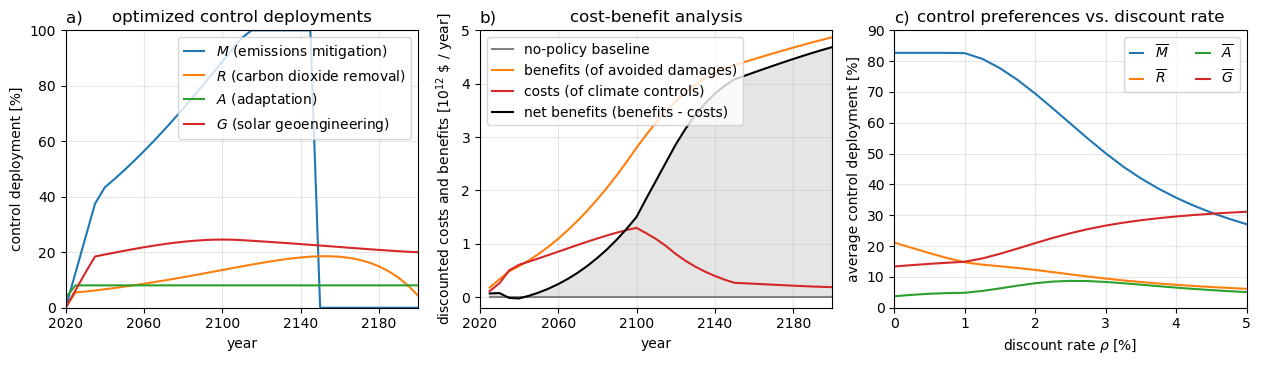

Maximum warming: 1.186373185757678

In [236]:
fig = figure(figsize=(12.75,3.75))

fig.add_subplot(1,3,1)
plot_controls(model)
legend(handlelength=1.5, loc="upper right")
title("a)", loc="left")

ax = fig.add_subplot(1,3,2)
plot_benefits(model, discounting=true)
legend(handlelength=1.5, loc="upper left")
title("b)", loc="left")
ylim([-0.2, 5.])

ax = fig.add_subplot(1,3,3)
plot(ρs, stat_dict["mitigate"], label=L"$\overline{M}$")
plot(ρs, stat_dict["remove"], label=L"$\overline{R}$")
plot(ρs, stat_dict["adapt"], label=L"$\overline{A}$")
plot(ρs, stat_dict["geoeng"], label=L"$\overline{G}$")
legend(ncol=2, handlelength=1.)
ylim([0, 0.9])
xlim([0., 0.05])
xticks(0:0.01:0.05, 0:1:5)
yticks(0:0.1:0.9, 0:10:90)
grid(true, alpha=0.3)
ylabel("average control deployment [%]")
title("control preferences vs. discount rate")
title("c)", loc="left")
xlabel(L"discount rate $\rho$ [%]")

tight_layout()
savefig("figures/default-benefits_controls_and_benefits.png", dpi=200, bbox_inches="tight")

print("Maximum warming: ", maximum(T(model, M=true, R=true, G=true, A=true)))

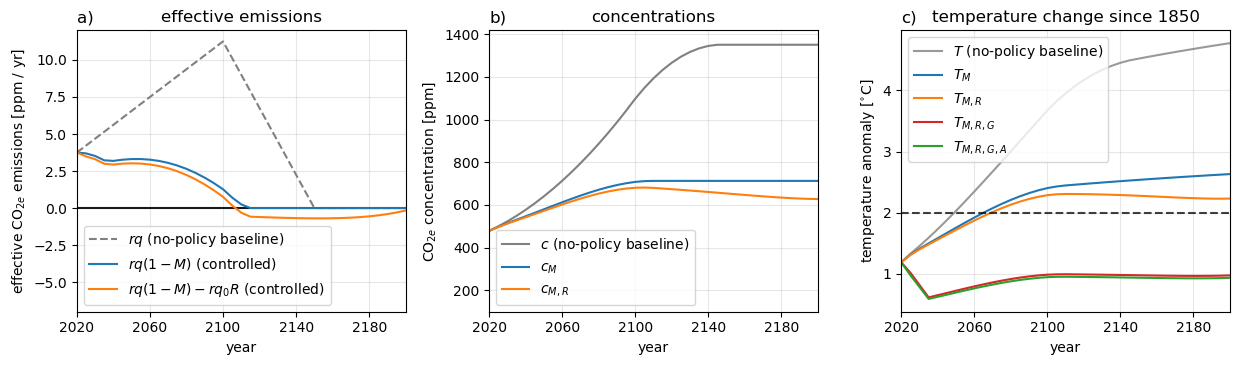

In [162]:
figure(figsize=(12.5,3.75))

subplot(1,3,1)
plot_emissions(model)
ylim([-7, 12])
legend(fontsize=10, loc="bottom left")
title("a)", loc="left")
subplot(1,3,2)
plot_concentrations(model)
legend()
title("b)", loc="left")
subplot(1,3,3)
plot_temperatures(model)
legend(loc="upper left")
title("c)", loc="left")
tight_layout()
savefig("figures/SI_default-temp_carbon_and_temperatures_cost-benefit.png", dpi=200, bbox_inches="tight")

#### Approach 2: Avoiding damage thresholds

In [178]:
model = ClimateModel(ClimateMARGO.IO.included_configurations["default"])
@time optimize_controls!(model);

Solve_Succeeded
  0.077068 seconds (107.62 k allocations: 4.457 MiB)


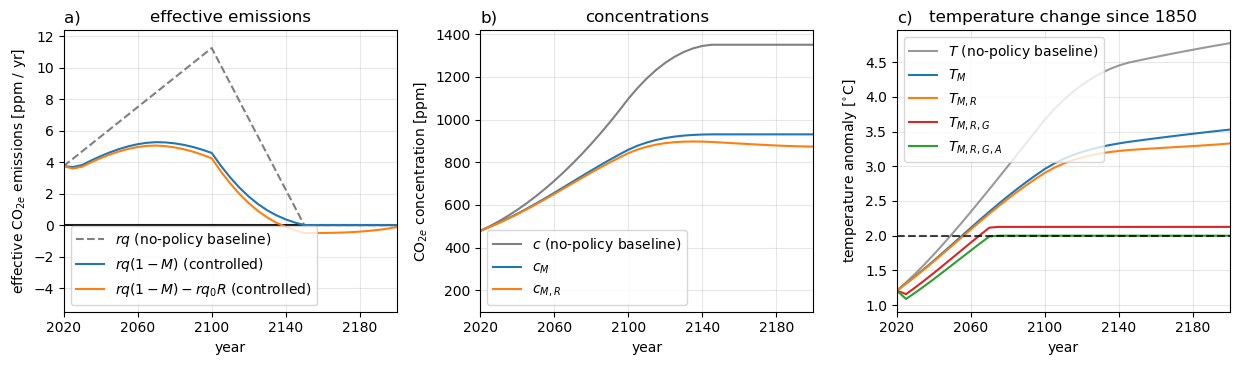

In [179]:
figure(figsize=(12.5,3.75))

subplot(1,3,1)
plot_emissions(model)
legend()
title("a)", loc="left")
subplot(1,3,2)
plot_concentrations(model)
legend()
title("b)", loc="left")
subplot(1,3,3)
plot_temperatures(model)
legend(loc="upper left")
title("c)", loc="left")
tight_layout()
savefig("figures/default-temp_carbon_and_temperatures.png", dpi=200, bbox_inches="tight")

In [185]:
base_model = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]));

ρs = 0.:0.0005:0.05
CGs = 0.:0.004:0.20;
models = Array{ClimateModel}(undef, size(ρs,1), size(CGs,1));

for (i, ρ) in enumerate(ρs)
    for (j, CG) in enumerate(CGs)
        tmp = deepcopy(base_model)
        tmp.economics.ρ = ρ
        tmp.economics.geoeng_cost = CG
        optimize_controls!(tmp, print_raw_status=false)
        models[i, j] = tmp
    end
end

GFmax = Array{Float64}(undef, size(ρs,1), size(CGs,1));
for (i, ρ) in enumerate(ρs)
    for (j, CG) in enumerate(CGs)
        GFmax[i,j] = maximum(F(models[i,j], M=true, R=true) - F(models[i,j], M=true, R=true, G=true))
    end
end

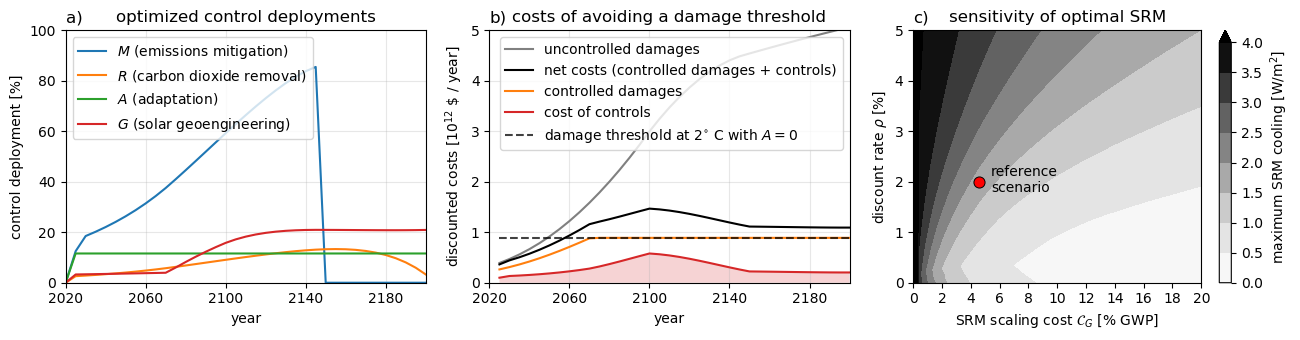

Net Present Control Costs = 53.46693576822394 trillion USD

In [216]:
figure(figsize=(13.2,3.5))

subplot(1,3,1)
plot_controls(model)
legend(loc="upper left")
title("a)", loc="left")

subplot(1,3,2)
plot_damages(model)
legend(loc="upper right")
title("b)", loc="left")
ylim([0, 5])

subplot(1,3,3)
GFlev = 0.:0.5:4
contourf(CGs, ρs, GFmax, cmap="Greys", levels=GFlev, extend="max")
colorbar(label = L"maximum SRM cooling [W/m$^{2}$]", ticks=GFlev)
plot([base_model.economics.geoeng_cost], [base_model.economics.ρ], "ro", label="reference scenario", markeredgecolor="k", markersize=8, markeredgewidth=0.7)
annotate("reference\nscenario", (0.054, 0.0179))
yticks(0.:0.01:0.05, 0:1:5)
xticks(0.:0.02:0.2, 0:2:20)
xlabel(L"SRM scaling cost $\mathcal{C}_{G}$ [% GWP]")
ylabel(L"discount rate $\rho$ [%]")
title("sensitivity of optimal SRM")
title("c)", loc="left")

tight_layout()
savefig("figures/default-temp_controls_and_damages.png", dpi=200, bbox_inches="tight")

print("Net Present Control Costs = ", net_present_cost(model, M=true, R=true, G=true, A=true), " trillion USD")